In [1]:
INPUT_DIR=r'C:\Users\Yash Sharma\Desktop\project\DATASET'
OUTPUT_DIR =r'C:\Users\Yash Sharma\Desktop\project'

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

Vocabulary Size: 508
Maximum Caption Length: 32
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/15
2/2 [==============================] - 17s 4s/step - loss: 6.1597 - val_loss: 5.8021
Epoch 2/15
2/2 [==============================] - 1s 833ms/step - loss: 4.9568 - val_loss: 6.2231
Epoch 3/15
2/2 [==============================] - 1s 889ms/step - loss: 4.2132 - val_loss: 6.8890
Epoch 4/15
2/2 [==============================] - 1s 783ms/step - loss: 3.7592 - val_loss: 6.8811
Epoch 5/15
2/2 [==============================] - 1s 846ms/step - loss: 3.4354 - val_loss: 7.0358
Epoch 6/15
2/2 [==============================] - 1s 785ms/step - loss: 3.1892 - val_loss: 7.4472
Epoch 7/15
2/2 [==============================] - 1s 727ms/step - loss: 3.0585 - val_loss: 7.9915
Epoch 8/15
2/2 [==============================] - 1s 933ms/step - loss: 2.9348 - val_loss: 8.3967
Epoch 9/15
2/2 [=====

  0%|          | 0/6 [00:00<?, ?it/s]

D:\python\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\python\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.333333
BLEU-2: 0.086066
---------------------Actual---------------------
startseq god brahma painting in sitting posture endseq
startseq hindu deity brahma giving blessing endseq
startseq lord brahma painting with multiple heads and hands endseq
startseq god brahma drawing wearing lots of jewellary endseq
startseq god brahma portrait with white beared and moustache endseq
--------------------Predicted--------------------
startseq brahma brahma brahma painting with endseq


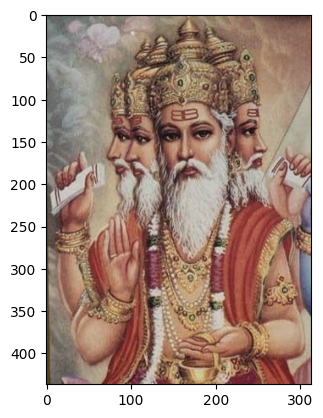

In [6]:
# Import necessary libraries
import os
import pickle
import numpy as np
from PIL import Image
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, RepeatVector, Multiply, Lambda, Activation, Dot
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt

# Load the ResNet152 model
model = ResNet152(weights='imagenet')
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    image_feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    image_features[image_id] = image_feature

# Save the image features to a pickle file
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features_resnet152.pkl'), 'wb'))

# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features_resnet152.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

# Rest of the code remains the same...

# ... (Continue with the rest of your code)

# Note: Make sure to update any paths or filenames according to your project structure.
# Rest of the code...

# Load captions from the text file
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    image_id = image_id.split('.')[0]
    caption = " ".join(captions)
    image_to_captions_mapping[image_id].append(caption)

# Clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

clean(image_to_captions_mapping)

# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Save the tokenizer
with open('tokenizer_resnet152.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer_resnet152.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())

# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys:
            captions = image_to_captions_mapping[image_id]

            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    batch_count += 1

                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

# Encoder model
inputs1 = Input(shape=(2048,))  # Adjust the input shape according to ResNet-152 output size
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])
attention_scores = Activation('softmax')(attention)
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)

# Set the number of epochs, batch size
epochs = 15
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
              validation_data=test_generator, validation_steps=validation_steps,
              verbose=1)

model.save(OUTPUT_DIR+'/mymodel_resnet152.h5')

# Function to get a word from an index
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

# Function to predict a caption
def predict_caption(model, image_features, tokenizer, max_caption_length):
    caption = 'startseq'
    
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        predicted_index = np.argmax(yhat)
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        caption += " " + predicted_word
        
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    actual_captions = image_to_captions_mapping[key]
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    actual_captions_words = [caption.split() for caption in actual_captions]
    predicted_caption_words = predicted_caption.split()
    
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

# Function to generate and display captions
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    
    plt.imshow(image)

# Example usage
generate_caption("image_1.jpeg")


In [7]:
from tabulate import tabulate

# Initialize lists to store BLEU scores and loss values
bleu_1_scores = []
bleu_2_scores = []
loss_values = []

# ...

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    # Train the model for one epoch
    history = model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
                        validation_data=test_generator, validation_steps=validation_steps,
                        verbose=1)
    
    # Append loss value to the list
    loss_values.append(history.history['loss'][0])
    
    # ...

    # Evaluate BLEU scores after each epoch
    actual_captions_list = []
    predicted_captions_list = []

    for key in tqdm(test):
        actual_captions = image_to_captions_mapping[key]
        predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

        actual_captions_words = [caption.split() for caption in actual_captions]
        predicted_caption_words = predicted_caption.split()

        actual_captions_list.append(actual_captions_words)
        predicted_captions_list.append(predicted_caption_words)

    # Calculate BLEU-1 and BLEU-2 scores
    bleu_1 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0))
    
    # Append scores to the lists
    bleu_1_scores.append(bleu_1)
    bleu_2_scores.append(bleu_2)

    # Display the table after each epoch
    table = tabulate({'Epoch': [epoch + 1], 'Loss': [history.history['loss'][0]], 'BLEU-1': [bleu_1], 'BLEU-2': [bleu_2]}, headers='keys', tablefmt='pretty')
    print(table)


Epoch 1/15
2/2 [==============================] - 1s 534ms/step - loss: 2.0324 - val_loss: 10.9239


  0%|          | 0/6 [00:00<?, ?it/s]

D:\python\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


+-------+-------------------+--------------------+------------------------+
| Epoch |       Loss        |       BLEU-1       |         BLEU-2         |
+-------+-------------------+--------------------+------------------------+
|   1   | 2.032383918762207 | 0.3118356616772059 | 8.056726535149356e-155 |
+-------+-------------------+--------------------+------------------------+
Epoch 2/15
2/2 [==============================] - 1s 566ms/step - loss: 1.9986 - val_loss: 11.4223


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+--------------------+------------------------+
| Epoch |        Loss        |       BLEU-1       |         BLEU-2         |
+-------+--------------------+--------------------+------------------------+
|   2   | 1.9986159801483154 | 0.4107142857142857 | 9.559652820360722e-155 |
+-------+--------------------+--------------------+------------------------+
Epoch 3/15
2/2 [==============================] - 1s 582ms/step - loss: 1.8988 - val_loss: 11.9092


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+-------------------+---------------------+-------------------------+
| Epoch |       Loss        |       BLEU-1        |         BLEU-2          |
+-------+-------------------+---------------------+-------------------------+
|   3   | 1.898841381072998 | 0.24946852934176475 | 7.2061552834883834e-155 |
+-------+-------------------+---------------------+-------------------------+
Epoch 4/15
2/2 [==============================] - 1s 524ms/step - loss: 1.7508 - val_loss: 12.2961


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+---------------------+-------------------------+
| Epoch |        Loss        |       BLEU-1        |         BLEU-2          |
+-------+--------------------+---------------------+-------------------------+
|   4   | 1.7507867813110352 | 0.24946852934176475 | 7.2061552834883834e-155 |
+-------+--------------------+---------------------+-------------------------+
Epoch 5/15
2/2 [==============================] - 1s 617ms/step - loss: 1.7239 - val_loss: 12.7833


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+-------------------+--------+------------------------+
| Epoch |       Loss        | BLEU-1 |         BLEU-2         |
+-------+-------------------+--------+------------------------+
|   5   | 1.723881721496582 |  0.28  | 7.893165907175875e-155 |
+-------+-------------------+--------+------------------------+
Epoch 6/15
2/2 [==============================] - 1s 626ms/step - loss: 1.6458 - val_loss: 13.4726


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+--------------------+------------------------+
| Epoch |        Loss        |       BLEU-1       |         BLEU-2         |
+-------+--------------------+--------------------+------------------------+
|   6   | 1.6457548141479492 | 0.3461538461538461 | 8.776205752480093e-155 |
+-------+--------------------+--------------------+------------------------+
Epoch 7/15
2/2 [==============================] - 1s 564ms/step - loss: 1.5359 - val_loss: 14.0086


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+--------------------+------------------------+
| Epoch |        Loss        |       BLEU-1       |         BLEU-2         |
+-------+--------------------+--------------------+------------------------+
|   7   | 1.5359400510787964 | 0.3469387755102041 | 8.786150464738599e-155 |
+-------+--------------------+--------------------+------------------------+
Epoch 8/15
2/2 [==============================] - 1s 493ms/step - loss: 1.4965 - val_loss: 14.3891


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+--------------------+------------------------+
| Epoch |        Loss        |       BLEU-1       |         BLEU-2         |
+-------+--------------------+--------------------+------------------------+
|   8   | 1.4965274333953857 | 0.3018316807262162 | 8.116685494782027e-155 |
+-------+--------------------+--------------------+------------------------+
Epoch 9/15
2/2 [==============================] - 1s 581ms/step - loss: 1.5202 - val_loss: 14.6734


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|   9   | 1.5202338695526123 | 0.3061224489795918 | 0.08437491760265975 |
+-------+--------------------+--------------------+---------------------+
Epoch 10/15
2/2 [==============================] - 1s 603ms/step - loss: 1.3046 - val_loss: 15.2865


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|  10   | 1.3046355247497559 | 0.30763392637619097 | 0.11578920341075771 |
+-------+--------------------+---------------------+---------------------+
Epoch 11/15
2/2 [==============================] - 1s 533ms/step - loss: 1.3640 - val_loss: 16.0209


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+--------------------+---------------------+
| Epoch |        Loss        |       BLEU-1       |       BLEU-2        |
+-------+--------------------+--------------------+---------------------+
|  11   | 1.3639683723449707 | 0.2708333333333333 | 0.08030200930495263 |
+-------+--------------------+--------------------+---------------------+
Epoch 12/15
2/2 [==============================] - 1s 512ms/step - loss: 1.2415 - val_loss: 16.5452


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+--------------------+-----------------------+
| Epoch |        Loss        |       BLEU-1       |        BLEU-2         |
+-------+--------------------+--------------------+-----------------------+
|  12   | 1.2414653301239014 | 0.3518518518518519 | 8.84814306859306e-155 |
+-------+--------------------+--------------------+-----------------------+
Epoch 13/15
2/2 [==============================] - 1s 633ms/step - loss: 1.2119 - val_loss: 16.7659


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|  13   | 1.2119240760803223 | 0.32786885245901637 | 0.07720914364821829 |
+-------+--------------------+---------------------+---------------------+
Epoch 14/15
2/2 [==============================] - 1s 595ms/step - loss: 1.1761 - val_loss: 17.2449


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|  14   | 1.1761199235916138 | 0.30763392637619097 | 0.11578920341075771 |
+-------+--------------------+---------------------+---------------------+
Epoch 15/15
2/2 [==============================] - 1s 535ms/step - loss: 1.1065 - val_loss: 17.7946


  0%|          | 0/6 [00:00<?, ?it/s]

+-------+--------------------+---------------------+---------------------+
| Epoch |        Loss        |       BLEU-1        |       BLEU-2        |
+-------+--------------------+---------------------+---------------------+
|  15   | 1.1065001487731934 | 0.30763392637619097 | 0.11578920341075771 |
+-------+--------------------+---------------------+---------------------+
